# Ridge and Lasso Regression

# 1. Brief Overview

Ridge and Lasso regression are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. Here ‘large’ can typically mean either of two things:

<ol>
<li>Large enough to enhance the tendency of a model to overfit (as low as 10 variables might cause overfitting)</li>
<li>Large enough to cause computational challenges. With modern systems, this situation might arise in case of millions or billions of features</li>
</ol>

Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and practical use cases differ substantially. If you’ve heard of them before, you must know that they work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. These are called ‘regularization’ techniques. The key difference is in how they assign penalty to the coefficients:

<ol>
<li><b>Ridge Regression:</b></li>
<ul>
    <li>Performs L2 regularization, i.e. adds penalty equivalent to <b>square of the magnitude</b> of coefficients</li>
<li>Minimization objective = LS Obj + α * (sum of square of coefficients)</li>
</ul>
<li><b>Lasso Regression:</b></li>
<ul>
<li>Performs L1 regularization, i.e. adds penalty equivalent to <b>absolute value of the magnitude</b> of coefficients</li>
<li>Minimization objective = LS Obj + α * (sum of absolute value of coefficients)</li>
</ul>
</ol>

Note that here ‘LS Obj’ refers to ‘least squares objective’, i.e. the linear regression objective without regularization.

If terms like ‘penalty’ and ‘regularization’ seem very unfamiliar to you, don’t worry we’ll talk about these in more detail through the course of this article. Before digging further into how they work, lets try to get some intuition into why penalizing the magnitude of coefficients should work in the first place.

# 2. Why Penalize the Magnitude of Coefficients?

Lets try to understand the impact of model complexity on the magnitude of coefficients. As an example, I have simulated a <b>sine curve</b> (between 60° and 300°) and added some random noise using the following code:

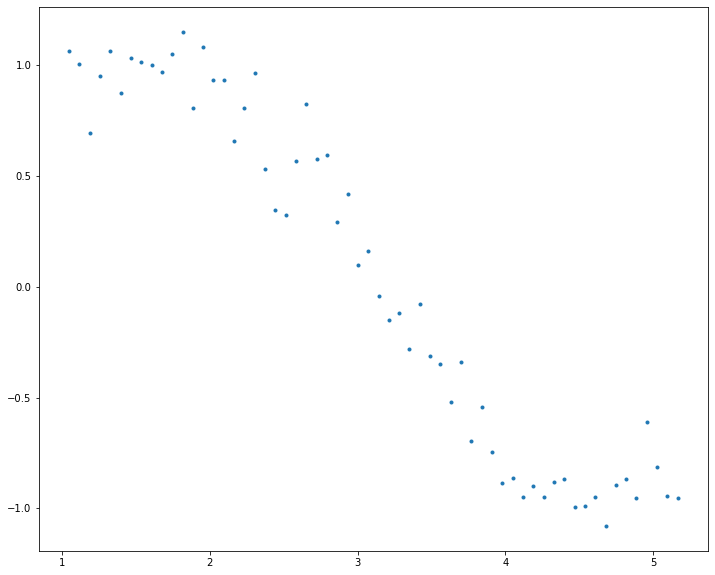

In [3]:
#Importing libraries. The same will be used throughout the article.
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10
import warnings
warnings.filterwarnings('ignore')

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)  #Setting seed for reproducibility
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')

This resembles a sine curve but not exactly because of the noise. We’ll use this as an example to test different scenarios in this article. Let’s try to estimate the sine function using <b>polynomial regression</b> with powers of x from 1 to 15. Let’s add a column for each power upto 15 in our dataframe. This can be accomplished using the following code:

In [4]:
for i in range(2,16):  #power of 1 is already there
    colname = 'x_%d'%i      #new var will be x_power
    data[colname] = data['x']**i
print(data.head())

          x         y       x_2       x_3       x_4       x_5       x_6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x_7       x_8        x_9       x_10       x_11       x_12       x_13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x_14       x_15  
0   1.907219   1.997235  
1   4.707635   5

Now that we have all the 15 powers, let’s make 15 different linear regression models with each model containing variables with powers of x from 1 to the particular model number. For example, the feature set of model 8 will be – {x, x_2, x_3, … ,x_8}.

First, we’ll define a generic function which takes in the required maximum power of x as an input and returns a list containing – [ model RSS, intercept, coef_x, coef_x2, … upto entered power ]. Here RSS refers to ‘Residual Sum of Squares’ which is nothing but the sum of square of errors between the predicted and actual values in the training data set. The python code defining the function is:

In [5]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
def linear_regression(data, power, models_to_plot):
    #initialize predictors:
    predictors=['x']
    if power>=2:
        predictors.extend(['x_%d'%i for i in range(2,power+1)])
    
    #Fit the model
    linreg = LinearRegression(normalize=True)
    linreg.fit(data[predictors],data['y'])
    y_pred = linreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered power
    if power in models_to_plot:
        plt.subplot(models_to_plot[power])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for power: %d'%power)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([linreg.intercept_])
    ret.extend(linreg.coef_)
    return ret

Note that this function will not plot the model fit for all the powers but will return the RSS and coefficients for all the models. I’ll skip the details of the code for now to maintain brevity. I’ll be happy to discuss the same through comments below if required.

Now, we can make all 15 models and compare the results. For ease of analysis, we’ll store all the results in a Pandas dataframe and plot 6 models to get an idea of the trend. Consider the following code:

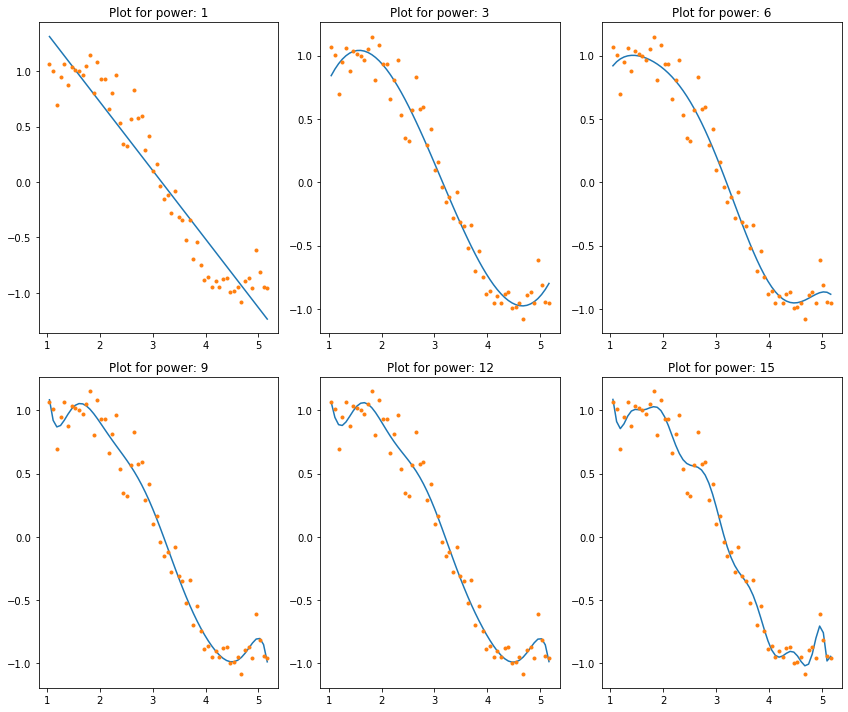

In [6]:
#Initialize a dataframe to store the results:
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['model_pow_%d'%i for i in range(1,16)]
coef_matrix_simple = pd.DataFrame(index=ind, columns=col)

#Define the powers for which a plot is required:
models_to_plot = {1:231,3:232,6:233,9:234,12:235,15:236}

#Iterate through all powers and assimilate results
for i in range(1,16):
    coef_matrix_simple.iloc[i-1,0:i+2] = linear_regression(data, power=i, models_to_plot=models_to_plot)

This clearly aligns with our initial understanding. As the model complexity increases, the models tends to fit even smaller deviations in the training data set. Though this leads to overfitting, lets keep this issue aside for some time and come to our main objective, i.e. the impact on the magnitude of coefficients. This can be analysed by looking at the data frame created above.

In [7]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_simple

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
model_pow_1,3.3,2,-0.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_2,3.3,1.9,-0.58,-0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_3,1.1,-1.1,3,-1.3,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_4,1.1,-0.27,1.7,-0.53,-0.036,0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_5,1,3,-5.1,4.7,-1.9,0.33,-0.021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_6,0.99,-2.8,9.5,-9.7,5.2,-1.6,0.23,-0.014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_7,0.93,19,-56,69,-45,17,-3.5,0.4,-0.019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_8,0.92,43,-1.4e+02,1.8e+02,-1.3e+02,58,-15,2.4,-0.21,0.0077,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_9,0.87,1.7e+02,-6.1e+02,9.6e+02,-8.5e+02,4.6e+02,-1.6e+02,37,-5.2,0.42,-0.015,NaN,NaN,NaN,NaN,NaN,NaN
model_pow_10,0.87,1.4e+02,-4.9e+02,7.3e+02,-6e+02,2.9e+02,-87,15,-0.81,-0.14,0.026,-0.0013,NaN,NaN,NaN,NaN,NaN


<img src='img/rig_1.png'>

It is clearly evident that the <b>size of coefficients increase exponentially with increase in model complexity.</b> I hope this gives some intuition into why putting a constraint on the magnitude of coefficients can be a good idea to reduce model complexity.

Lets try to understand this even better.

What does a large coefficient signify? It means that we’re putting a lot of emphasis on that feature, i.e. the particular feature is a good predictor for the outcome. When it becomes too large, the algorithm starts modelling intricate relations to estimate the output and ends up overfitting to the particular training data.

I hope the concept is clear. I’ll be happy to discuss further in comments if needed. Now, lets understand ridge and lasso regression in detail and see how well they work for the same problem.

# 3. Ridge Regression

As mentioned before, ridge regression performs <b>‘L2 regularization‘</b>, i.e. it adds a factor of sum of squares of coefficients in the optimization objective. Thus, ridge regression optimizes the following:

### Objective = RSS + α * (sum of square of coefficients)

Here, α (alpha) is the parameter which balances the amount of emphasis given to minimizing RSS vs minimizing sum of square of coefficients. α can take various values:

<ol>
<li><b>α = 0:</b></li>
<ul>
<li>The objective becomes same as simple linear regression.</li>
<li>We’ll get the same coefficients as simple linear regression.</li>
</ul>

<li><b>α = ∞:</b></li>
<ul>
<li>The coefficients will be zero. Why? Because of infinite weightage on square of coefficients, anything less than zero will make the objective infinite.</li>
</ul>

<li><b>0 < α < ∞:</b></li>
<ul>
<li>The magnitude of α will decide the weightage given to different parts of objective.</li>
<li>The coefficients will be somewhere between 0 and ones for simple linear regression.</li>
</ul>
</ol>

I hope this gives some sense on how α would impact the magnitude of coefficients. One thing is for sure that any non-zero value would give values less than that of simple linear regression. By how much? We’ll find out soon. Leaving the mathematical details for later, lets see ridge regression in action on the same problem as above.

First, lets define a generic function for ridge regression similar to the one defined for simple linear regression. The Python code is:

In [8]:
from sklearn.linear_model import Ridge
def ridge_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(data[predictors],data['y'])
    y_pred = ridgereg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([ridgereg.intercept_])
    ret.extend(ridgereg.coef_)
    return ret

Note the ‘Ridge’ function used here. It takes ‘alpha’ as a parameter on initialization. Also, keep in mind that normalizing the inputs is generally a good idea in every type of regression and should be used in case of ridge regression as well.

Now, lets analyze the result of Ridge regression for 10 different values of α ranging from 1e-15 to 20. These values have been chosen so that we can easily analyze the trend with change in values of α. These would however differ from case to case.

Python Code:

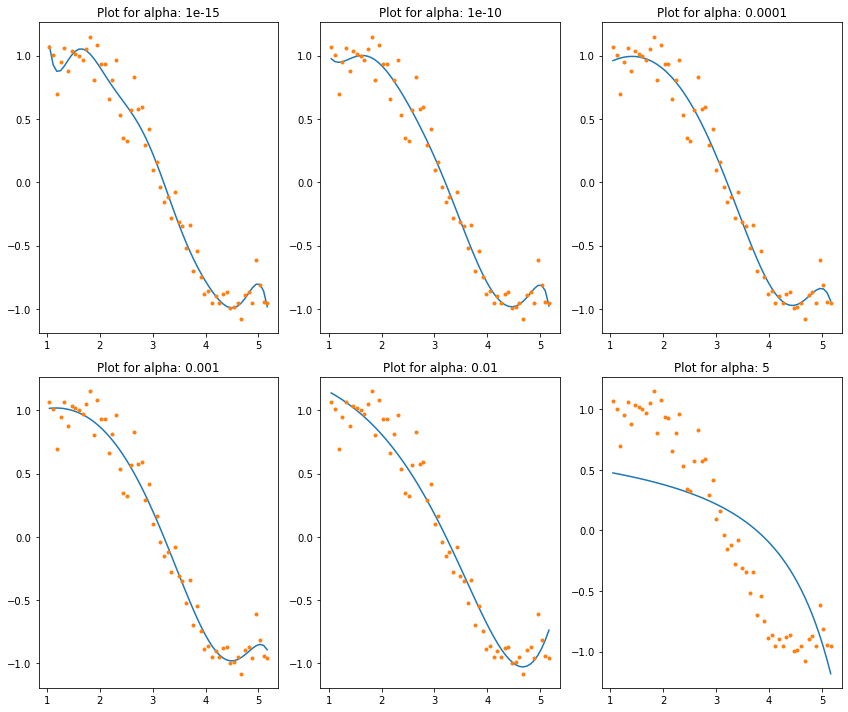

In [9]:
#Initialize predictors to be set of 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Set the different values of alpha to be tested
alpha_ridge = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]

#Initialize the dataframe for storing coefficients.
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_ridge[i] for i in range(0,10)]
coef_matrix_ridge = pd.DataFrame(index=ind, columns=col)

models_to_plot = {1e-15:231, 1e-10:232, 1e-4:233, 1e-3:234, 1e-2:235, 5:236}
for i in range(10):
    coef_matrix_ridge.iloc[i,] = ridge_regression(data, predictors, alpha_ridge[i], models_to_plot)

Here we can clearly observe that <b>as the value of alpha increases, the model complexity reduces.</b> Though higher values of alpha reduce overfitting, significantly high values can cause underfitting as well (eg. alpha = 5). Thus alpha should be chosen wisely. A widely accept technique is cross-validation, i.e. the value of alpha is iterated over a range of values and the one giving higher cross-validation score is chosen.

Lets have a look at the value of coefficients in the above models:

Python Code:

In [10]:
#Set the display format to be scientific for ease of analysis
pd.options.display.float_format = '{:,.2g}'.format
coef_matrix_ridge

,rss,intercept,coef_x_1,coef_x_2,coef_x_3,coef_x_4,coef_x_5,coef_x_6,coef_x_7,coef_x_8,coef_x_9,coef_x_10,coef_x_11,coef_x_12,coef_x_13,coef_x_14,coef_x_15
alpha_1e-15,0.87,94,-3e+02,3.8e+02,-2.4e+02,68,-1.2,-3.7,0.3,0.19,-0.021,-0.0077,0.0011,0.00025,-6.3e-05,4.6e-06,-9e-08
alpha_1e-10,0.92,11,-29,31,-15,2.9,0.17,-0.091,-0.011,0.002,0.00064,2.4e-05,-2e-05,-4.2e-06,2.2e-07,2.3e-07,-2.3e-08
alpha_1e-08,0.95,1.3,-1.5,1.7,-0.68,0.039,0.016,0.00016,-0.00036,-5.4e-05,-2.9e-07,1.1e-06,1.9e-07,2e-08,3.9e-09,8.2e-10,-4.6e-10
alpha_0.0001,0.96,0.56,0.55,-0.13,-0.026,-0.0028,-0.00011,4.1e-05,1.5e-05,3.7e-06,7.4e-07,1.3e-07,1.9e-08,1.9e-09,-1.3e-10,-1.5e-10,-6.2e-11
alpha_0.001,1,0.82,0.31,-0.087,-0.02,-0.0028,-0.00022,1.8e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,1.3,-0.088,-0.052,-0.01,-0.0014,-0.00013,7.2e-07,4.1e-06,1.3e-06,3e-07,5.6e-08,9e-09,1.1e-09,4.3e-11,-3.1e-11,-1.5e-11
alpha_1,5.6,0.97,-0.14,-0.019,-0.003,-0.00047,-7e-05,-9.9e-06,-1.3e-06,-1.4e-07,-9.3e-09,1.3e-09,7.8e-10,2.4e-10,6.2e-11,1.4e-11,3.2e-12
alpha_5,14,0.55,-0.059,-0.0085,-0.0014,-0.00024,-4.1e-05,-6.9e-06,-1.1e-06,-1.9e-07,-3.1e-08,-5.1e-09,-8.2e-10,-1.3e-10,-2e-11,-3e-12,-4.2e-13
alpha_10,18,0.4,-0.037,-0.0055,-0.00095,-0.00017,-3e-05,-5.2e-06,-9.2e-07,-1.6e-07,-2.9e-08,-5.1e-09,-9.1e-10,-1.6e-10,-2.9e-11,-5.1e-12,-9.1e-13
alpha_20,23,0.28,-0.022,-0.0034,-0.0006,-0.00011,-2e-05,-3.6e-06,-6.6e-07,-1.2e-07,-2.2e-08,-4e-09,-7.5e-10,-1.4e-10,-2.5e-11,-4.7e-12,-8.7e-13


The table looks like:

<img src='img/rig_2.png'>

This straight away gives us the following inferences:

<ol>
<li>The RSS increases with increase in alpha, this model complexity reduces</li>
<li>An alpha as small as 1e-15 gives us significant reduction in magnitude of coefficients. How? Compare the coefficients in the first row of this table to the last row of simple linear regression table.</li>
<li>High alpha values can lead to significant underfitting. Note the rapid increase in RSS for values of alpha greater than 1</li>
<li>Though the coefficients are <b>very very small</b>, they are <b>NOT zero.</b></li>
</ol>

The first 3 are very intuitive. But #4 is also a crucial observation. Let’s reconfirm the same by determining the number of zeros in each row of the coefficients data set:

Python Code:

In [13]:
coef_matrix_ridge.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15     0
alpha_1e-10     0
alpha_1e-08     0
alpha_0.0001    0
alpha_0.001     0
alpha_0.01      0
alpha_1         0
alpha_5         0
alpha_10        0
alpha_20        0
dtype: int64

This confirms that all the 15 coefficients are greater than zero in magnitude (can be +ve or -ve). Remember this observation and have a look again until its clear. This will play an important role in later while comparing ridge with lasso regression.

# 4. Lasso Regression

LASSO stands for Least Absolute Shrinkage and Selection Operator. I know it doesn’t give much of an idea but there are 2 key words here – ‘absolute‘ and ‘selection‘.

Lets consider the former first and worry about the latter later.

Lasso regression performs <b>L1 regularization</b>, i.e. it adds a factor of sum of absolute value of coefficients in the optimization objective. Thus, lasso regression optimizes the following:

### Objective = RSS + α * (sum of absolute value of coefficients)

Here, α (alpha) works similar to that of ridge and provides a trade-off between balancing RSS and magnitude of coefficients. Like that of ridge, α can take various values. Lets iterate it here briefly:

<ol>
<li>α = 0: Same coefficients as simple linear regression</li>
<li>α = ∞: All coefficients zero (same logic as before)</li>
<li>0 < α < ∞: coefficients between 0 and that of simple linear regression</li>
</ol>

Yes its <i>appearing to be very similar to Ridge till now.</i> But just hang on with me and you’ll know the difference by the time we finish. Like before, lets run lasso regression on the same problem as above. First we’ll define a generic function:

In [14]:
from sklearn.linear_model import Lasso
def lasso_regression(data, predictors, alpha, models_to_plot={}):
    #Fit the model
    lassoreg = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
    lassoreg.fit(data[predictors],data['y'])
    y_pred = lassoreg.predict(data[predictors])
    
    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(data['x'],y_pred)
        plt.plot(data['x'],data['y'],'.')
        plt.title('Plot for alpha: %.3g'%alpha)
    
    #Return the result in pre-defined format
    rss = sum((y_pred-data['y'])**2)
    ret = [rss]
    ret.extend([lassoreg.intercept_])
    ret.extend(lassoreg.coef_)
    return ret

Notice the additional parameters defined in Lasso function – ‘max_iter‘. This is the maximum number of iterations for which we want the model to run if it doesn’t converge before. This exists for Ridge as as well but setting this to a higher than default value was required in this case. Why? I’ll come to this in next section, just keep it in the back of the envelope.

Lets check the output for 10 different values of alpha using the following code:

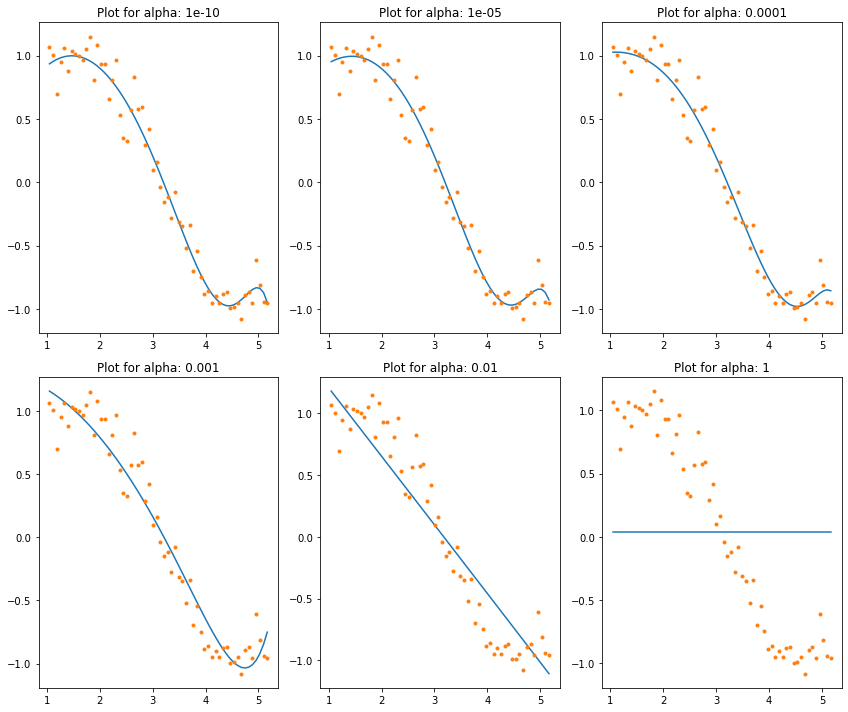

In [15]:
#Initialize predictors to all 15 powers of x
predictors=['x']
predictors.extend(['x_%d'%i for i in range(2,16)])

#Define the alpha values to test
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

#Initialize the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(1,16)]
ind = ['alpha_%.2g'%alpha_lasso[i] for i in range(0,10)]
coef_matrix_lasso = pd.DataFrame(index=ind, columns=col)

#Define the models to plot
models_to_plot = {1e-10:231, 1e-5:232,1e-4:233, 1e-3:234, 1e-2:235, 1:236}

#Iterate over the 10 alpha values:
for i in range(10):
    coef_matrix_lasso.iloc[i,] = lasso_regression(data, predictors, alpha_lasso[i], models_to_plot)

This again tells us that the model complexity decreases with increase in the values of alpha. But notice the straight line at alpha=1. Appears a bit strange to me. Let’s explore this further by looking at the coefficients:

<img src='img/rig_3.png'>

Apart from the expected inference of higher RSS for higher alphas, we can see the following:

<ol>
<li>For the same values of alpha, the coefficients of lasso regression are much smaller as compared to that of ridge regression (compare row 1 of the 2 tables).</li>
<li>For the same alpha, lasso has higher RSS (poorer fit) as compared to ridge regression</li>
<li>Many of the coefficients are zero even for very small values of alpha</li>
</ol>

Inferences #1,2 might not generalize always but will hold for many cases. The real difference from ridge is coming out in the last inference. Lets check the number of coefficients which are zero in each model using following code:

In [17]:
coef_matrix_lasso.apply(lambda x: sum(x.values==0),axis=1)

alpha_1e-15      0
alpha_1e-10      0
alpha_1e-08      0
alpha_1e-05      8
alpha_0.0001    10
alpha_0.001     12
alpha_0.01      13
alpha_1         15
alpha_5         15
alpha_10        15
dtype: int64

We can observe that <b>even for a small value of alpha, a significant number of coefficients are zero.</b> This also explains the horizontal line fit for alpha=1 in the lasso plots, its just a baseline model! This phenomenon of most of the coefficients being zero is called <b>‘sparsity‘</b>. Although lasso performs feature selection, this level of sparsity is achieved in special cases only which we’ll discuss towards the end.

This has some really interesting implications on the use cases of lasso regression as compared to that of ridge regression. But before coming to the final comparison, lets take a <b>bird’s eye view</b> of the mathematics behind why coefficients are zero in case of lasso but not ridge.

In [ ]:
'''
LINEAR, RIDGE AND LASSO REGRESSION
'''
# importing requuired libraries
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

# read test and train file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('\n\n---------DATA---------------\n\n')
print(train.head())

#splitting into training and test
## try building model with the different features and compare the result.
X = train.loc[:,['Outlet_Establishment_Year','Item_MRP']]
x_train, x_cv, y_train, y_cv = train_test_split(X,train.Item_Outlet_Sales,random_state=5)

print('--------Trainig Linear Regression Model---------------')
lreg = LinearRegression()
#training the model
lreg.fit(x_train,y_train)

#predicting on cv
pred = lreg.predict(x_cv)

#calculating mse
mse = np.mean((pred - y_cv)**2)
print('\nMean Sqaured Error = ',mse )

#Let us take a look at the coefficients of this linear regression model.
# calculating coefficients
coeff = DataFrame(x_train.columns)

coeff['Coefficient Estimate'] = Series(lreg.coef_)

print(coeff)

print('\n\nModel performance on Test data = ')
print(lreg.score(x_cv,y_cv))

print('\n\n---------Training Ridge Regression Model----------------')

ridge = Ridge()
ridge.fit(x_train,y_train)
pred1 = ridge.predict(x_cv)
mse_1 = np.mean((pred1-y_cv)**2)

print('\n\nMean Squared Error = ',mse_1)

# calculating coefficients
coeff = DataFrame(x_train.columns)
coeff['Coefficient Estimate'] = Series(ridge.coef_)
print(coeff)

print('\n\nModel performance on Test data = ')
print(ridge.score(x_cv,y_cv))


print('\n\n---------Training Lasso Regression Model----------------')

lasso = Lasso()
lasso.fit(x_train,y_train)
pred2 = lasso.predict(x_cv)
mse_2 = np.mean((pred2-y_cv)**2)

print('\n\nMean Squared Error = ',mse_2)

# calculating coefficients
coeff = DataFrame(x_train.columns)
coeff['Coefficient Estimate'] = Series(lasso.coef_)
print(coeff)

print('\n\nModel performance on Test data = ')
print(lasso.score(x_cv,y_cv))

# 5. Sneak Peak into Statistics (Optional)

Let’s start by reviewing the basic structure of data in a regression problem.

<img src='img/rig_4.png'>

In this infographic, you can see there are 4 data elements:

<ol>
<li><b>X:</b>the matrix of input features (nrow: N, ncol: M+1)</li>
<li><b>Y:</b> the actual outcome variable (length:N)</li>
<li><b>Yhat:</b>these are predicted values of Y (length:N)</li>
<li><b>W:</b>the weights or the coefficients (length: M+1)</li>
</ol>

Here, N is the total number of data points available and M is the total number of features. X has M+1 columns because of M features and 1 intercept.

The predicted outcome for any data point i is:

<img src='img/rig_5.png'>

It is simply the weighted sum of each data point with coefficients as the weights. This prediction is achieved by finding the optimum value of weights based on certain criteria, which depends on the type of regression algorithm being used. Lets consider all 3 cases:

### 1. Simple Linear Regression

The objective function (also called as the cost) to be minimized is just the RSS (Residual Sum of Squares), i.e. the sum of squared errors of the predicted outcome as compared to the actual outcome. This can be depicted mathematically as:



<img src='img/rig_6.png'>

In order to minimize this cost, we generally use a ‘gradient descent’ algorithm. I’ll not go into the details right now but you can refer this. The overall algorithm works as:

Here the important step is #2.1.1 where we compute the gradient. Gradient is nothing but a partial differential of the cost with respect to a particular weight (denoted as w<sub>j</sub>). The gradient for the j<sup>th</sup> weight will be:

<img src='img/rig_7.png'>

This is formed from 2 parts:

<ol>
<li>2*{..} : This is formed because we’ve differentiated the square of the term in {..}</li>
    <li>-w<sub>j</sub> : This is the differentiation of the part in {..} wrt wj. Since its a summation, all other would become 0 and only w<sub>j</sub> would remain.</li>
</ol>

Step #2.1.2 involves updating the weights using the gradient. This update step for simple linear regression looks like:

<img src='img/rig_8.png'>

I hope you are able to follow along. Note the +ve sign in the RHS is formed after multiplication of 2 -ve signs. I would like to explain point #2 of the gradient descent algorithm mentioned above <b>‘iterate till not converged‘</b>. Here convergence refers to attaining the optimum solution within pre-defined limit.

It is checked using the value of gradient. If the gradient is small enough, that means we are very close to optimum and further iterations won’t have a substantial impact on coefficients. The lower-limit on gradient can be changed using the <b>‘tol‘</b> parameter.

Lets consider the case of ridge regression now.

### 2. Ridge Regression

The objective function (also called the cost) to be minimized is the RSS plus the sum of square of the magnitude of weights. This can be depicted mathematically as:

<img src='img/rig_9.png'>

In this case, the gradient would be:

<img src='img/rig_10.png'>

Again in the regularization part of gradient, only wj remains and all other would become zero. The corresponding update rule is:

<img src='img/rig_11.png'>

Here we can see that second part of the RHS is same as that of simple linear regression. Thus, ridge regression is equivalent to reducing the weight by a factor of (1-2λη) first and then applying the same update rule as simple linear regression. I hope this gives some intuition into why the coefficients get reduced to small numbers but never become zero.

Note that the criteria for convergence in this case remains similar to simple linear regression, i.e. checking the value of gradients. Lets discuss Lasso regression now.

### 3. Lasso Regression

The objective function (also called the cost) to be minimized is the RSS plus the sum of absolute value of the magnitude of weights. This can be depicted mathematically as:

<img src='img/rig_12.png'>

In this case, the gradient is not defined as the absolute function is not differentiable at x=0. This can be illustrated as:

<img src='img/rig_13.png'>

We can see that the parts on the left and right side of 0 are straight lines with defined derivates but the function can’t be differentiated at x=0. In this case, we have to use a different technique called as <b>coordinate descent</b> which is based on the concept of sub-gradients. One of the coordinate descent follows the following algorithms (this is also the default in sklearn):

#2.1.1 might look too generalized. But I’m intentionally leaving the details and jumping to the update rule:

<img src='img/rig_14.png'>

Here <b>g(w<sub>-j</sub>)</b>represents (but not exactly) the difference between actual outcome and the predicted outcome considering <b>all EXCEPT the j<sup>th</sup> variable.</b> If this value is small, it means that the algorithm is able to predict the outcome fairly well even without the jth variable and thus it can be removed from the equation by setting a zero coefficient. This gives us some intuition into why the coefficients become zero in case of lasso regression.

In coordinate descent, checking convergence is another issue. Since gradients are not defined, we need an alternate method. Many alternatives exist but the simplest one is to <b>check the step size of the algorithm.</b> We can check the maximum difference in weights in any particular cycle over all feature weights (#2.1 of algo above).

If this is lower than ‘tol’ specified, algo will stop. The convergence is not as fast as gradient descent and we might have to set the ‘max_iter’ parameter if a warning appears saying that the algo stopped before convergence. This is why I specified this parameter in the Lasso generic function.

Lets summarize our understanding by comparing the coefficients in all the three cases using the following visual, which shows how the ridge and lasso coefficients behave in comparison to the simple linear regression case.

<img src='img/rig_15.png'>

Apologies for the lack of visual appeal. But I think it is good enough to re-inforced the following facts:

<ol>
<li>The ridge coefficients are a reduced factor of the simple linear regression coefficients and thus never attain zero values but very small values</li>
<li>The lasso coefficients become zero in a certain range and are reduced by a constant factor, which explains there low magnitude in comparison to ridge.</li>
</ol>

Before going further, one important issue in case of both ridge and lasso regression is <b>intercept handling</b>. Generally, regularizing the intercept is not a good idea and it should be left out of regularization. This requires slight changes in the implementation, which I’ll leave for you to explore.

Now, lets come to the concluding part where we compare the Ridge and Lasso techniques and see where these can be used.

### 6. Conclusion

Now that we have a fair idea of how ridge and lasso regression work, lets try to consolidate our understanding by comparing them and try to appreciate their specific use cases. I will also compare them with some alternate approaches. Lets analyze these under three buckets:

### 1. Key Difference

<ul>
<li><b>Ridge:</b> It includes all (or none) of the features in the model. Thus, the major advantage of ridge regression is coefficient shrinkage and reducing model complexity.</li>
<li><b>Lasso:</b>Along with shrinking coefficients, lasso performs feature selection as well. (Remember the ‘selection‘ in the lasso full-form?) As we observed earlier, some of the coefficients become exactly zero, which is equivalent to the particular feature being excluded from the model.</li>
</ul>

Traditionally, techniques like <b>stepwise regression</b> were used to perform feature selection and make parsimonious models. But with advancements in Machine Learning, ridge and lasso regression provide very good alternatives as they give much <b>better output,</b> require <b>fewer tuning parameters</b> and can be <b>automated</b> to a large extend.

### 2. Typical Use Cases

<ul>
<li><b>Ridge:</b>It is majorly used to prevent overfitting. Since it includes all the features, it is not very useful in case of exorbitantly high #features, say in millions, as it will pose computational challenges.</li>
<li><b>Lasso:</b>Since it provides sparse solutions, it is generally the model of choice (or some variant of this concept) for modelling cases where the #features are in millions or more. In such a case, getting a sparse solution is of great computational advantage as the features with zero coefficients can simply be ignored.</li>
</ul>

Its not hard to see why the stepwise selection techniques become practically very cumbersome to implement in high dimensionality cases. Thus, lasso provides a significant advantage.

### 3. Presence of Highly Correlated Features

<ul>
<li><b>Ridge:</b> It generally works well even in presence of highly correlated features as it will include all of them in the model but the coefficients will be distributed among them depending on the correlation.</li>
<li><b>Lasso:</b>It arbitrarily selects any one feature among the highly correlated ones and reduced the coefficients of the rest to zero. Also, the chosen variable changes randomly with change in model parameters. This generally doesn’t work that well as compared to ridge regression.</li>
</ul>

This disadvantage of lasso can be observed in the example we discussed above. Since we used a polynomial regression, the variables were highly correlated. ( Not sure why? Check the output of data.corr() ). Thus, we saw that even small values of alpha were giving significant sparsity (i.e. high #coefficients as zero).

Along with Ridge and Lasso, Elastic Net is another useful techniques which combines both L1 and L2 regularization. It can be used to balance out the pros and cons of ridge and lasso regression. I encourage you to explore it further.